In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.autograd import Variable
from IPython.display import HTML
from torchsummary import summary
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/home/hyc/miniconda3/envs/metagan/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
args = {'epoch':30000,
        'n_way':5,
        'k_spt':1,
        'k_qry':15,
        'img_sz':64,
        "tasks_per_batch":10,
        'img_c':3,
        'task_num': 10,
        'meta_lr':1e-3,
        'update_lr':0.01,
        'update_step':5,
        'update_step_test':10,
        'save_path':'results'
       }

In [4]:
img_shape = (3, 64, 64)

In [5]:
from dataloader import train_data_generator,test_data_generator
train_data_generator = train_data_generator(args)
dataloader = torch.utils.data.DataLoader(train_data_generator, args["tasks_per_batch"], shuffle=True, num_workers=16)

load dataset/BelgiumTSC
load complete time 3.290234327316284
load dataset/ArTS
load complete time 3.1598546504974365
load dataset/chinese_traffic_sign
load complete time 0.5926766395568848
load dataset/CVL
load complete time 0.3971841335296631
load dataset/FullJCNN2013
load complete time 0.2602715492248535
load dataset/logo_2k
load complete time 1.026320219039917


/home/hyc/miniconda3/envs/metagan/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


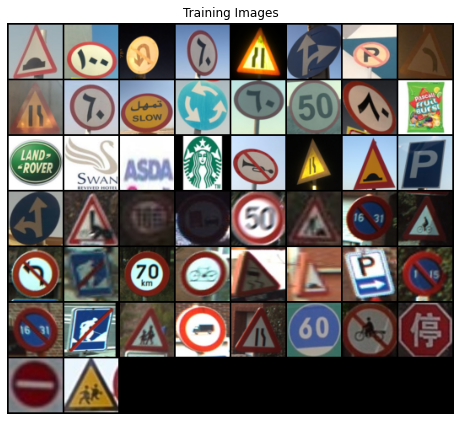

In [6]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
data_iter = iter(dataloader)
# Plot some training images
real_batch = next(data_iter)
real_batch = real_batch[0]
real_batch = real_batch.view(real_batch.size(0)*real_batch.size(1),real_batch.size(2),real_batch.size(3),real_batch.size(4))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(args['n_way'], args['n_way'])
        self.ngpu = ngpu
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(100 + args['n_way'], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [9]:
np.random.normal(0, 1, (10 ** 2, 100)).shape

(100, 100)

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (label_emb): Embedding(5, 5)
  (model): Sequential(
    (0): Linear(in_features=105, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=12288, bias=True)
    (12): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(args['n_way'], args['n_way'])

        self.model = nn.Sequential(
            nn.Linear(args['n_way'] + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [12]:
# Create the Discriminator
netD = Discriminator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
# summary(netD,(3,64,64))

Discriminator(
  (label_embedding): Embedding(5, 5)
  (model): Sequential(
    (0): Linear(in_features=12293, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [13]:
adversarial_loss = nn.MSELoss()

real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(beta1, 0.999))

In [14]:
cuda = True if torch.cuda.is_available() else False

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


In [24]:
from torchvision.utils import save_image
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, 100))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = netG(z, labels)
    return gen_imgs
    # save_image(gen_imgs.data, "cgan_result/%d.png" % batches_done, nrow=n_row, normalize=True)

In [16]:
G_losses = []
D_losses = []
img_list = []
iters = 0
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        imgs = data[0].to(device)
        imgs = imgs.view(imgs.size(0)*imgs.size(1),imgs.size(2),imgs.size(3),imgs.size(4))
        labels = data[1].to(device)
        labels = labels.view(labels.size(0)*labels.size(1))
        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizerG.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, 100))))
        gen_labels = Variable(LongTensor(np.random.randint(0, args['n_way'], batch_size)))

        # Generate a batch of images
        gen_imgs = netG(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = netD(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizerD.zero_grad()

        # Loss for real images
        validity_real = netD(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = netD(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizerD.step()
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        if (i % 300) == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
        batches_done = epoch * len(dataloader) + i
        if batches_done % 400 == 0:
            sample_image(n_row=5, batches_done=batches_done)

[Epoch 0/10] [Batch 0/2400] [D loss: 0.545151] [G loss: 1.075264]
[Epoch 0/10] [Batch 300/2400] [D loss: 0.148947] [G loss: 0.706505]
[Epoch 0/10] [Batch 600/2400] [D loss: 0.104981] [G loss: 0.684459]
[Epoch 0/10] [Batch 900/2400] [D loss: 0.231953] [G loss: 1.030175]
[Epoch 0/10] [Batch 1200/2400] [D loss: 0.152802] [G loss: 0.992349]
[Epoch 0/10] [Batch 1500/2400] [D loss: 0.145675] [G loss: 0.617762]
[Epoch 0/10] [Batch 1800/2400] [D loss: 0.220453] [G loss: 0.328095]
[Epoch 0/10] [Batch 2100/2400] [D loss: 0.143262] [G loss: 0.419255]
[Epoch 1/10] [Batch 0/2400] [D loss: 0.108144] [G loss: 0.499871]
[Epoch 1/10] [Batch 300/2400] [D loss: 0.171874] [G loss: 0.649260]
[Epoch 1/10] [Batch 600/2400] [D loss: 0.143813] [G loss: 0.424353]
[Epoch 1/10] [Batch 900/2400] [D loss: 0.124374] [G loss: 0.541174]
[Epoch 1/10] [Batch 1200/2400] [D loss: 0.128002] [G loss: 0.561351]
[Epoch 1/10] [Batch 1500/2400] [D loss: 0.156007] [G loss: 0.533053]
[Epoch 1/10] [Batch 1800/2400] [D loss: 0.1540

In [36]:
img_list = []
a = sample_image(n_row=5, batches_done=batches_done).cpu().detach().numpy() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


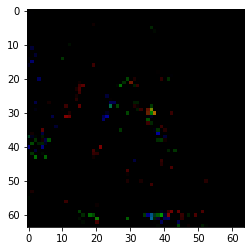

In [42]:
plt.imshow(np.transpose(a[0],(1,2,0)))

In [43]:
np.transpose(a[0],(1,2,0))

array([[[-0.9393363 , -0.9629271 , -0.82466173],
        [-0.9075139 , -0.66120756, -0.8121899 ],
        [-0.9565609 , -0.30524722, -0.39913413],
        ...,
        [-0.9539016 , -0.9706315 , -0.873772  ],
        [-0.9735401 , -0.7887976 , -0.98254937],
        [-0.97261137, -0.6190231 , -0.9314824 ]],

       [[-0.942409  , -0.43333536, -0.77833366],
        [-0.98977375, -0.6421859 ,  0.00753721],
        [-0.9616442 , -0.6919253 , -0.87808025],
        ...,
        [-0.97943485, -0.94842196, -0.94218016],
        [-0.97870225, -0.9871613 , -0.68932295],
        [-0.9815044 , -0.9918715 , -0.9427047 ]],

       [[-0.6772721 , -0.9696128 , -0.81790686],
        [-0.9152051 , -0.97865295, -0.8696002 ],
        [-0.89757735, -0.69193196, -0.8695023 ],
        ...,
        [-0.9526069 , -0.8217513 , -0.9728438 ],
        [-0.99394387, -0.97819823, -0.9763393 ],
        [-0.99566007, -0.9824562 , -0.9301202 ]],

       ...,

       [[-0.7624378 , -0.933296  , -0.8765821 ],
        [-0

In [27]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

torch.Size([25, 3, 64, 64])

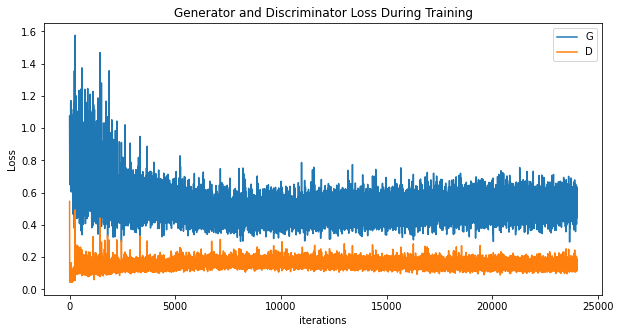

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())